In [1]:
import numpy as np
import pandas as pd
import pickle
import torch
import sys
import matplotlib.pyplot as plt
from matplotlib import cm,colors
from warnings import filterwarnings
from tqdm import tqdm
import seaborn as sns
from torch import nn
import os
import bioframe
import anndata
from argparse import Namespace
import json

filterwarnings('ignore')
sys.path.append('/home/che/perturb-project/git/gene_ptb_prediction/src')

import scanpy as sc
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=False)
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
import pytorch_lightning as pl

In [2]:
from inference import *
from utils import SCDATA_sampler, MMD_loss
from dataset import SCDataset
from torch.utils.data import DataLoader

In [3]:
# set random seed
rand_seed = 12
pl.seed_everything(rand_seed)
use_gears_top_20 = False
adata_file_path = '/home/che/perturb-project/git/gene_ptb_prediction/scdata_file_path.csv'
device = 'cuda:3'

Seed set to 12


In [4]:
# Specify the dataset name and the test set name
dataset_name = 'replogle_k562_essential' # replogle_k562_essential or dixit_bmdc_3hr
use_hvg = True
if dataset_name == 'dixit_bmdc_3hr':
    test_set_name = 'all_train'
elif dataset_name == 'replogle_k562_essential':
    test_set_name = 'random_fold_1'

if use_hvg:
    dataset_str = f'{dataset_name}_hvg'
else:
    dataset_str = dataset_name

In [5]:
opts = Namespace(
    dataset_name = dataset_name,
    use_hvg = use_hvg,
    test_set_name = test_set_name,
    recon_loss = 'mmd',
    null_label = 'zeros',
    epochs = 100,
    tolerance_epochs = 20,
    mxAlpha = 2.0,
    validation_set_ratio = 0.1,
    validation_ood_ratio = 0.15,
    latdim_ctrl=50,
    latdim_ptb=50,
    geneset_num=50,
    random_seed = rand_seed,
    model_name = 'best_model.pt'
)

savedir = (f'/home/che/perturb-project/predict_model/result/rna/{dataset_str}/'
           f'latdim_ctrl_{opts.latdim_ctrl}_latdim_ptb_{opts.latdim_ptb}_geneset_num_{opts.geneset_num}/{test_set_name}/recon_loss_{opts.recon_loss}/'
           f'null_label_{opts.null_label}/epochs_{opts.epochs}/tolerance_epochs_{opts.tolerance_epochs}/mxAlpha_{opts.mxAlpha}/'
           f'val_{opts.validation_set_ratio}_ood_{opts.validation_ood_ratio}/'
           f'random_seed_{opts.random_seed}/DepMap_GeneEffect_mvae_attention_vae_14_2_run1739678684'
)

opts.savedir = savedir
opts.model_id = savedir.split('/')[-1]
opts.model_id

'DepMap_GeneEffect_mvae_attention_vae_14_2_run1739678684'

# Perturbation modules
In this script, we are trying to find and identify the cluster/modules of perturbation targets whose have similar effects.

Specifically, we will explore the clustering in the perturbation latent space.

In [6]:
# load in raw data
adata_file = pd.read_csv(adata_file_path)
adata_path = adata_file[(adata_file['dataset'] == dataset_name) & (adata_file['use_hvg'] == use_hvg)]['file_path'].values[0]
adata = sc.read(adata_path)
print('Read adata from', adata_path)

Read adata from /home/che/perturb-project/predict_model/dataset/replogle_k562/K562_essential_normalized_hvg.h5ad


### 1. Load trained model

In [7]:
assert test_set_name in opts.savedir
assert dataset_name in opts.savedir
print(test_set_name)
model = torch.load(f'{opts.savedir}/{opts.model_name}', map_location=device) if opts.savedir is not None else None
model.eval()
print('Loaded model from', f'{opts.savedir}/{opts.model_name}')

random_fold_1
Loaded model from /home/che/perturb-project/predict_model/result/rna/replogle_k562_essential_hvg/latdim_ctrl_50_latdim_ptb_50_geneset_num_50/random_fold_1/recon_loss_mmd/null_label_zeros/epochs_100/tolerance_epochs_20/mxAlpha_2.0/val_0.1_ood_0.15/random_seed_12/DepMap_GeneEffect_mvae_attention_vae_14_2_run1739678684/best_model.pt


In [8]:
result_dir = f"{opts.savedir}/{opts.model_name.split('.')[0]}"
if not os.path.exists(result_dir):
    os.makedirs(result_dir)
print(result_dir)

/home/che/perturb-project/predict_model/result/rna/replogle_k562_essential_hvg/latdim_ctrl_50_latdim_ptb_50_geneset_num_50/random_fold_1/recon_loss_mmd/null_label_zeros/epochs_100/tolerance_epochs_20/mxAlpha_2.0/val_0.1_ood_0.15/random_seed_12/DepMap_GeneEffect_mvae_attention_vae_14_2_run1739678684/best_model


### 2. Get the fine-tuned embeddings for each perturbation target

In [9]:
# first get train dataloader and test dataloader
from torch.utils.data import DataLoader, Subset
import json

with open(f'{opts.savedir}/config.json', 'rb') as f:
    config = json.load(f)

print('null vector type:', config['null_label'])
print('mxAlpha:', config['mxAlpha'])
print('reconstruction loss:', config['reconstruction_loss'])

with open(f'{opts.savedir}/split_idx.pkl', 'rb') as f:
    split_idx = pickle.load(f)
    train_idx = split_idx['train_idx']
    val_idx = split_idx['val_idx']
    infer_idx = split_idx['infer_idx']

dataset = SCDataset(modality='rna',
                    dataset = config['dataset'], 
                    leave_out_test_set_id = config['leave_out_test_set_id'],
                    perturb_targets=None, 
                    representation_type=config['label'], 
                    representation_type_2 = config['label_2'],
                    representation_type_3=config['label_3'],
                    min_counts=config['batch_size'],
                    use_hvg=config['use_hvg'],
                    random_seed=config['seed'],
                    gene_embs=None)

# Training dataloader
tain_idx_all = np.concatenate([train_idx, val_idx])
dataset1 = Subset(dataset, tain_idx_all) 
train_ptb_name = dataset.ptb_names[tain_idx_all] 
dataloader_train = DataLoader(
    dataset1,
    batch_sampler=SCDATA_sampler(dataset1, config['batch_size'], train_ptb_name),
    num_workers=0
)

# Test dataloader
if infer_idx is not None:
    dataset2 = Subset(dataset, infer_idx)
    infer_ptb_name = dataset.ptb_names[infer_idx]
    dataloader_infer = DataLoader(
        dataset2,
        batch_sampler=SCDATA_sampler(dataset2, config['batch_size'], infer_ptb_name),
        num_workers=0
    )

null vector type: zeros
mxAlpha: 2.0
reconstruction loss: mmd
Loading perturbation target embeddings from /home/che/perturb-project/data/gene_ptb_emb/DepMap/depmap_crispr_gene_effect_name_correct.pkl
loading split data from:  /home/che/perturb-project/git/gene_ptb_prediction/performance_eval/rna_data/replogle_k562_essential_hvg/splits.csv
leave_out_test_set_id:  random_fold_1
Loaded adata from:  /home/che/perturb-project/predict_model/dataset/replogle_k562/K562_essential_normalized_hvg.h5ad
Length of raw ptb_leave_out_list:  407
Length of filtered ptb_leave_out_list (after removing gene with counts <  32 ):  407
Checking for perturbation targets without embeddings in adata...
Perturbation targets without embeddings:  ['RPS27', 'RPS26', 'TIMM23B', 'CDK11A', 'NBPF12', 'KRTAP4-7', 'OR4F4', 'SMN2', 'FAM72D', 'FRG2', 'CASP8AP2', 'CCDC144NL', 'ALG1L', 'PLA2G10', 'SPDYE2', 'OR2A1', 'HIST2H2AA3', 'EIF3CL', 'GOLGA6L1', 'GTF2H2C', 'C14orf178', 'ARHGAP11B', 'NOMO3', 'LCE1C', 'POLR2A', 'NBPF15', '

In [10]:
model = model.to(device)
model.eval()

ptb_ft_dict = {}

for (i, X) in tqdm(enumerate(dataloader_train), total=len(dataloader_train), desc='Getting attention maps'):
    x = X[0] #control samples
    y = X[1] #perturbation samples
    c_1 = X[2] #perturbation labels (target 1)
    c_2 = X[3] #perturbation labels (target 2)
    gene_ptb = np.unique(X[4])[0] #perturbation gene

    x = x.to(device)
    c_1 = c_1.to(device)
    c_2 = c_2.to(device)

    with torch.no_grad():
        y_hat, _, _, _, latents = model(x,c_1, c_2, num_interv=2, return_latents=True)

    # check that rows are the same in latents
    assert torch.all(torch.eq(latents, latents[0]))
    latent = latents[0].cpu().numpy()
    assert len(latent) == model.z_dim_ptb
    del latents, y_hat
    
    if gene_ptb not in ptb_ft_dict:
        ptb_ft_dict[gene_ptb] = latent

Getting attention maps: 100%|██████████| 6572/6572 [00:27<00:00, 235.92it/s]


In [11]:
model = model.to(device)
model.eval()

ptb_ft_dict_test = {}

if infer_idx is not None:
    for (i, X) in tqdm(enumerate(dataloader_infer), total=len(dataloader_infer), desc='Getting attention maps for test set'):
        x = X[0] #control samples
        y = X[1] #perturbation samples
        c_1 = X[2] #perturbation labels (target 1)
        c_2 = X[3] #perturbation labels (target 2)
        gene_ptb = np.unique(X[4])[0] #perturbation gene

        x = x.to(device)
        c_1 = c_1.to(device)
        c_2 = c_2.to(device)

        with torch.no_grad():
            y_hat, _, _, _, latents = model(x,c_1, c_2, num_interv=2, return_latents=True)

        # check that rows are the same in latents
        assert torch.all(torch.eq(latents, latents[0]))
        latent = latents[0].cpu().numpy()
        assert len(latent) == model.z_dim_ptb
        del latents, y_hat
        
        if gene_ptb not in ptb_ft_dict_test:
            ptb_ft_dict_test[gene_ptb] = latent

Getting attention maps for test set: 100%|██████████| 1711/1711 [00:07<00:00, 240.74it/s]


In [12]:
len(ptb_ft_dict_test), len(ptb_ft_dict)

(402, 1591)

In [13]:
# stack them into anndata format

# Combine keys and values from both dictionaries
genes_test = list(ptb_ft_dict_test.keys())
values_test = np.array(list(ptb_ft_dict_test.values()))

genes_train = list(ptb_ft_dict.keys())
values_train = np.array(list(ptb_ft_dict.values()))

# Concatenate the gene lists and values
if infer_idx is not None:
    genes_combined = genes_test + genes_train
    values_combined = np.vstack([values_test, values_train])
else:
    genes_combined = genes_train
    values_combined = values_train

# Create 'gene' and 'split' metadata
gene_col = genes_test + genes_train
split_col = ['test'] * len(genes_test) + ['train'] * len(genes_train)

# Create a dataframe for adata.obs
obs_df = pd.DataFrame({
    'gene': gene_col,
    'split': split_col
})

# Create the AnnData object
adata_ptb = anndata.AnnData(X=values_combined, obs=obs_df)
print(adata_ptb)

AnnData object with n_obs × n_vars = 1993 × 50
    obs: 'gene', 'split'


In [14]:
ptb_ft_dict.keys()

dict_keys(['POLR2H', 'MED8', 'BUB3', 'COPS6', 'RBM42', 'GNL2', 'ARL4D', 'TRAPPC3', 'BUB1', 'PCBP1', 'MRPL22', 'CTDP1', 'FARS2', 'TRNT1', 'RPP40', 'RPP38', 'CCT2', 'SDAD1', 'CDC42', 'COPS4', 'PDRG1', 'MED19', 'C1orf109', 'CXXC1', 'VEZT', 'PTBP1', 'RFC1', 'BUD13', 'TUBB', 'PRPF4B', 'MED12', 'TTC4', 'RAD51D', 'PCF11', 'TRMT5', 'RPL18', 'MZF1', 'POLA1', 'RAD51', 'KDM2A', 'PMPCB', 'CCNH', 'SNRNP40', 'CAPZB', 'XPO1', 'TCERG1', 'CLK2', 'ANKS6', 'QARS', 'HSPA5', 'CHTOP', 'SNRNP35', 'HUS1', 'UQCRFS1', 'SF3B4', 'MAGOH', 'HECTD1', 'THOC2', 'NUMA1', 'RPAIN', 'SLU7', 'DNM1L', 'MRPL2', 'PSMD13', 'LST1', 'NSUN4', 'METTL16', 'PSMD4', 'DONSON', 'WBP1', 'EIF4G2', 'ZW10', 'TEFM', 'CWF19L2', 'CHMP7', 'ATP2A2', 'RUVBL1', 'MRPL24', 'UTP23', 'HSP90B1', 'DNAJC19', 'INO80B', 'GTF2H1', 'FAM32A', 'SLC25A3', 'ARCN1', 'HIST2H2BF', 'EIF3H', 'SNRPA1', 'MCM2', 'EIF2B1', 'MCMBP', 'C6orf15', 'SAE1', 'TNPO3', 'NAA38', 'NUP205', 'JAZF1', 'SLC7A5', 'DBF4', 'WDR75', 'EIF4E', 'EXOC2', 'GPS1', 'UTP18', 'NUF2', 'VPS37C', 'TTC

In [15]:
# quick check to make sure that the values are the same
if 'replogle_k562_essential' in dataset_name:
    test_gene = 'FTSJ3'
    # assert (ptb_ft_dict_test[test_gene] == adata_ptb[adata_ptb.obs['gene'] == 'UFL1'].X).all()
    assert (ptb_ft_dict[test_gene] == adata_ptb[adata_ptb.obs['gene'] == test_gene].X).all()

### Step 3. Load the gene modules identified in the original paper

In [16]:
if 'replogle_k562_essential' in dataset_name:
    # Get the perturbation clusters
    ptb_cluster = pd.read_csv('/home/che/perturb-project/git/gene_ptb_prediction/grn/gene_clusters/replogle/perturbation_clusters.csv')
    # subset to columns members and best_description
    ptb_cluster = ptb_cluster[['members', 'best_description']]
    # rename columns
    ptb_cluster.columns = ['gene_name', 'perturbation_cluster']
    # ptb_cluster['perturbation_cluster'] = ptb_cluster['perturbation_cluster'].apply(lambda x: np.nan if 'unknown' in str(x) else x)
    ptb_cluster = ptb_cluster[ptb_cluster['gene_name'].isin(adata_ptb.obs['gene'].values.tolist())]
elif dataset_name == 'dixit_bmdc_3hr':
    ptb_cluster = pd.read_csv('/home/che/perturb-project/git/gene_ptb_prediction/grn/gene_clusters/dixit/fig4b_ptb_modules_dc3hr.csv')
    ptb_cluster = ptb_cluster[['gene_name', 'perturbation_cluster']]
    ptb_cluster = ptb_cluster[ptb_cluster['gene_name'].isin(adata_ptb.obs['gene'].values.tolist())]

ptb_cluster.head(5)

,gene_name,perturbation_cluster
11,EXOC5,unknown 3
24,CBLL1,m6A mRNA methylation
25,METTL14,m6A mRNA methylation
26,METTL3,m6A mRNA methylation
27,PSMG1,m6A mRNA methylation


In [17]:
if dataset_name == 'replogle_k562_essential':
    ptb_cluster_greater_than_10 = ptb_cluster['perturbation_cluster'].value_counts()[ptb_cluster['perturbation_cluster'].value_counts() >= 10].index
    ptb_cluster = ptb_cluster[ptb_cluster['perturbation_cluster'].isin(ptb_cluster_greater_than_10)]
    ptb_cluster['perturbation_cluster'].nunique()

In [18]:
# give me duplicate gene_name in ptb_cluster
ptb_cluster[ptb_cluster.duplicated(subset=['gene_name'], keep=False)]

,gene_name,perturbation_cluster
211,LSM5,spliceosome
212,LSM5,spliceosome


In [19]:
# drop duplicates
ptb_cluster = ptb_cluster.drop_duplicates(subset='gene_name')
ptb_cluster

,gene_name,perturbation_cluster
40,ACTR6,histone acetylation 1
41,CFDP1,histone acetylation 1
43,H2AFZ,histone acetylation 1
46,KANSL2,histone acetylation 1
47,KANSL3,histone acetylation 1
...,...,...
695,TARS,"mitochondrial protein translocation, tRNA synt..."
697,TIMM44,"mitochondrial protein translocation, tRNA synt..."
698,TOMM22,"mitochondrial protein translocation, tRNA synt..."
699,TTC1,"mitochondrial protein translocation, tRNA synt..."


In [20]:
ptb_cluster[ptb_cluster['perturbation_cluster'] == 'mitochondrial protein translocation, tRNA synthesis, EIF2']

,gene_name,perturbation_cluster
661,AARS,"mitochondrial protein translocation, tRNA synt..."
662,CHCHD4,"mitochondrial protein translocation, tRNA synt..."
663,DNAJA3,"mitochondrial protein translocation, tRNA synt..."
664,DNAJC19,"mitochondrial protein translocation, tRNA synt..."
665,EIF2B1,"mitochondrial protein translocation, tRNA synt..."
666,EIF2B2,"mitochondrial protein translocation, tRNA synt..."
667,EIF2B3,"mitochondrial protein translocation, tRNA synt..."
668,EIF2B4,"mitochondrial protein translocation, tRNA synt..."
669,EIF2B5,"mitochondrial protein translocation, tRNA synt..."
670,FARSA,"mitochondrial protein translocation, tRNA synt..."


In [21]:
ptb_cluster['perturbation_cluster'].value_counts().head(20)

perturbation_cluster
40S ribosomal subunit, cytoplasmic                           82
60S ribosomal subunit, cytoplasmic                           52
mitochondrial protein translocation, tRNA synthesis, EIF2    36
39S ribosomal subunit, mitochondrial                         35
spliceosome                                                  31
Mediator complex                                             22
TFIIH/nucleotide excision repair                             22
DNA replication                                              19
exosome and mRNA turnover                                    12
Pol I and rRNA biosynthesis                                  12
translocon/protein glycosylation                             11
histone acetylation 1                                        10
vesicular trafficking                                        10
proteasome                                                   10
Name: count, dtype: int64

In [22]:
### append the perturbation_cluster information to adata_ptb
adata_ptb.obs = adata_ptb.obs.merge(ptb_cluster, left_on='gene', right_on='gene_name', how='left')
adata_ptb.obs = adata_ptb.obs.drop(columns='gene_name')
adata_ptb.obs

,gene,split,perturbation_cluster
0,DNMT1,test,NaN
1,RPL10A,test,"60S ribosomal subunit, cytoplasmic"
2,MRPL16,test,"39S ribosomal subunit, mitochondrial"
3,FNBP4,test,NaN
4,UFM1,test,NaN
...,...,...,...
1988,CPSF6,train,NaN
1989,SAP30BP,train,NaN
1990,KANSL1,train,NaN
1991,PSMA6,train,NaN


### Step 4. UMAP plots of target gene representations colored by perturbation clusters


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


<Axes: xlabel='UMAP1', ylabel='UMAP2'>

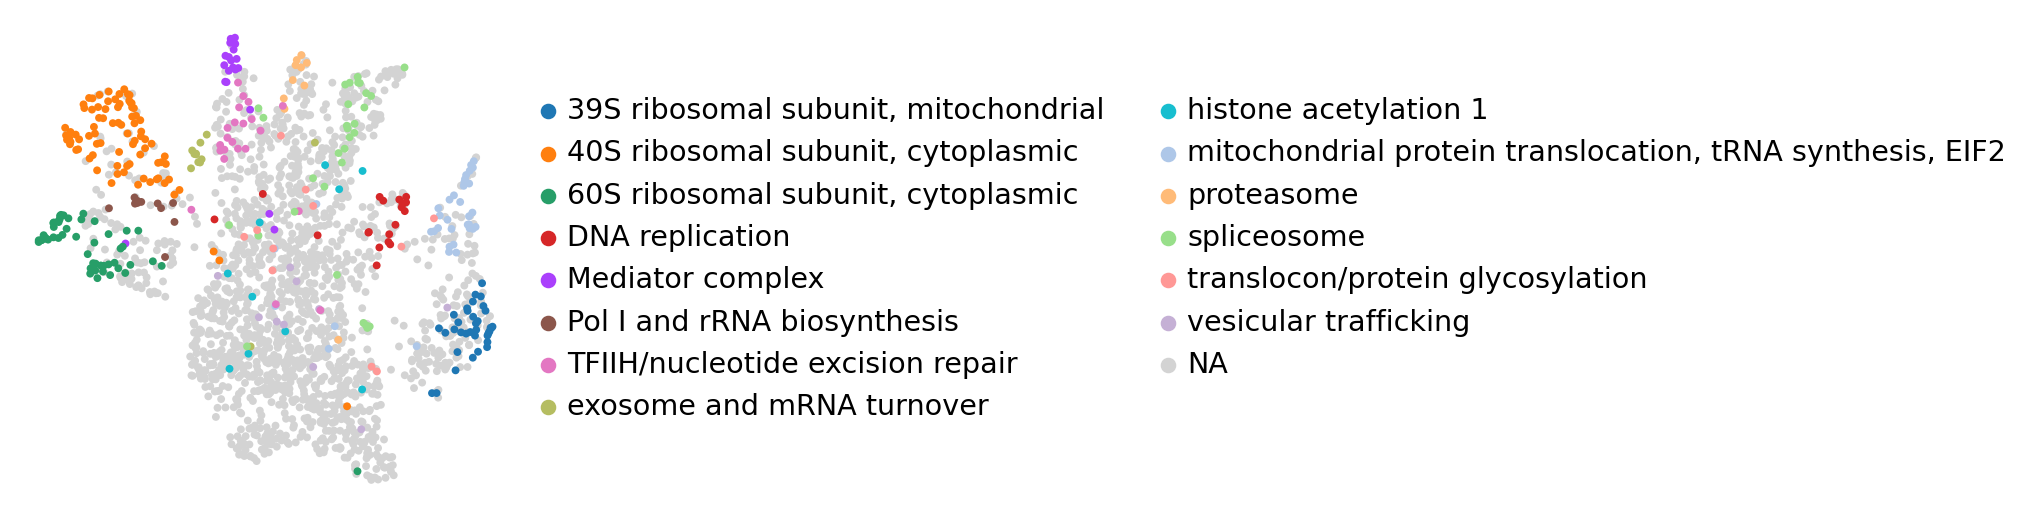

In [23]:
# plot UMAP
# sc.tl.pca(adata_ptb, svd_solver='arpack')
n_neighbors = 8
opts.n_neighbors = n_neighbors
min_dist = 0.5
opts.min_dist = min_dist
sc.pp.neighbors(adata_ptb, n_neighbors=n_neighbors, use_rep='X')
sc.tl.umap(adata_ptb, min_dist=min_dist)
sc.pl.umap(adata_ptb,
           size=100 if dataset_name == 'dixit_bmdc_3hr' else 50,
           color='perturbation_cluster',
           title='',
           show=False,  # To prevent showing before all plots are rendered
           cmap='tab20')

In [24]:
print(adata_ptb.obs.dtypes)

gene                      object
split                   category
perturbation_cluster    category
dtype: object


In [25]:
fig, axes = plt.subplots(1, 1, figsize=(3, 3))

# Plot 'perturbation_cluster_plot'
sc.pl.umap(adata_ptb,
           ax=axes,  # Specify the subplot
           size=100 if dataset_name == 'dixit_bmdc_3hr' else 50,
           color='perturbation_cluster',
           title='',
           show=False,  # To prevent showing before all plots are rendered
           cmap='tab20')

# Save the plot without the legend
axes.get_legend().remove()  # Remove the legend from the main plot
plt.tight_layout()
plt.savefig(f"{result_dir}/{opts.model_name.replace('.pt', '')}_umap_perturbation_cluster.png", dpi=300)
# plt.savefig(f"{result_dir}/{opts.model_name.replace('.pt', '')}_umap_perturbation_cluster.svg", format='svg')
plt.close(fig)

# Create and save the legend separately
fig_legend, ax_legend = plt.subplots(figsize=(10, 10))
handles, labels = axes.get_legend_handles_labels()
ax_legend.legend(handles, labels, loc='center', frameon=False)
ax_legend.axis('off')  # Turn off the axis
plt.tight_layout()
# plt.savefig(f"{result_dir}/{opts.model_name.replace('.pt', '')}_umap_perturbation_cluster_legend.png", dpi=300)
# plt.savefig(f"{result_dir}/{opts.model_name.replace('.pt', '')}_umap_perturbation_cluster_legend.svg", format='svg')
plt.close(fig_legend)

In [26]:
fig, axes = plt.subplots(1, 1, figsize=(3,3))

# Plot 'perturbation_cluster_plot'
sc.pl.umap(adata_ptb,
           ax=axes,  # Specify the subplot
           size=50,
           color='split',
           title='',
           show=False,  # To prevent showing before all plots are rendered
           cmap='tab20')

# Save the plot without the legend
axes.get_legend().remove()  # Remove the legend from the main plot
plt.tight_layout()
# plt.savefig(f"{result_dir}/{opts.model_name.replace('.pt', '')}_umap_split.png", dpi=300)
# plt.savefig(f"{result_dir}/{opts.model_name.replace('.pt', '')}_umap_split.svg", format='svg')
plt.close(fig)

# Create and save the legend separately
fig_legend, ax_legend = plt.subplots(figsize=(3, 3))
handles, labels = axes.get_legend_handles_labels()
ax_legend.legend(handles, labels, loc='center', frameon=False)
ax_legend.axis('off')  # Turn off the axis
plt.tight_layout()
# plt.savefig(f"{result_dir}/{opts.model_name.replace('.pt', '')}_umap_split_legend.png", dpi=300)
# plt.savefig(f"{result_dir}/{opts.model_name.replace('.pt', '')}_umap_split_legend.svg", format='svg')
plt.close(fig_legend)

<Axes: title={'center': 'UMAP by Split'}, xlabel='UMAP1', ylabel='UMAP2'>

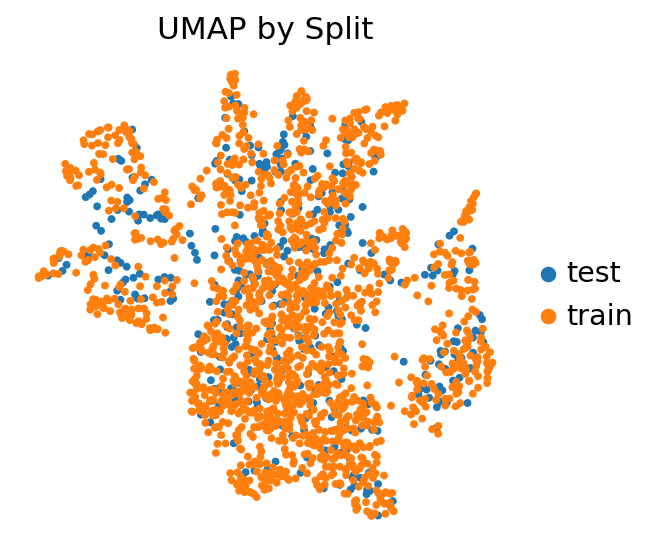

In [27]:
# Plot 'split_plot'
sc.pl.umap(adata_ptb,
        #    ax=axes[1],  # Specify the second subplot
           size=50,
           color='split',
           title='UMAP by Split',
           show=False,
           cmap='tab20')